# BASICS 02 - HOTS algorithm (Lagorce et al. 2017)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os
from timesurface import timesurface
from network import network
from utils import get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [3]:
transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform)
loader = get_loader(trainset, shuffle=True)
print(f'number of samples in the training set: {len(loader)}')

number of samples in the training set: 48


## Initialization of the network

In [4]:
name = 'homeohots_nothreshold'
homeo = True
timestr = '2022-05-11'
dataset_name = 'poker'

Rz = [2]
N_neuronz = [16]
tauz = [1e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

device -> cuda


## Unsupervised clustering

In [5]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
filtering_threshold = [None for L in range(len(Rz))]
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold, record = True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [02:37<00:00,  3.28s/it]


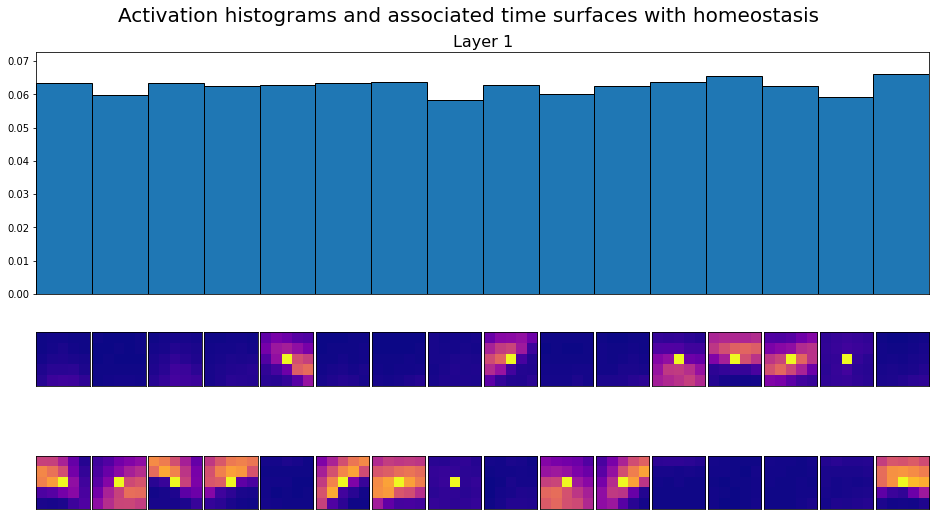

In [6]:
hots.plotlayers();

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

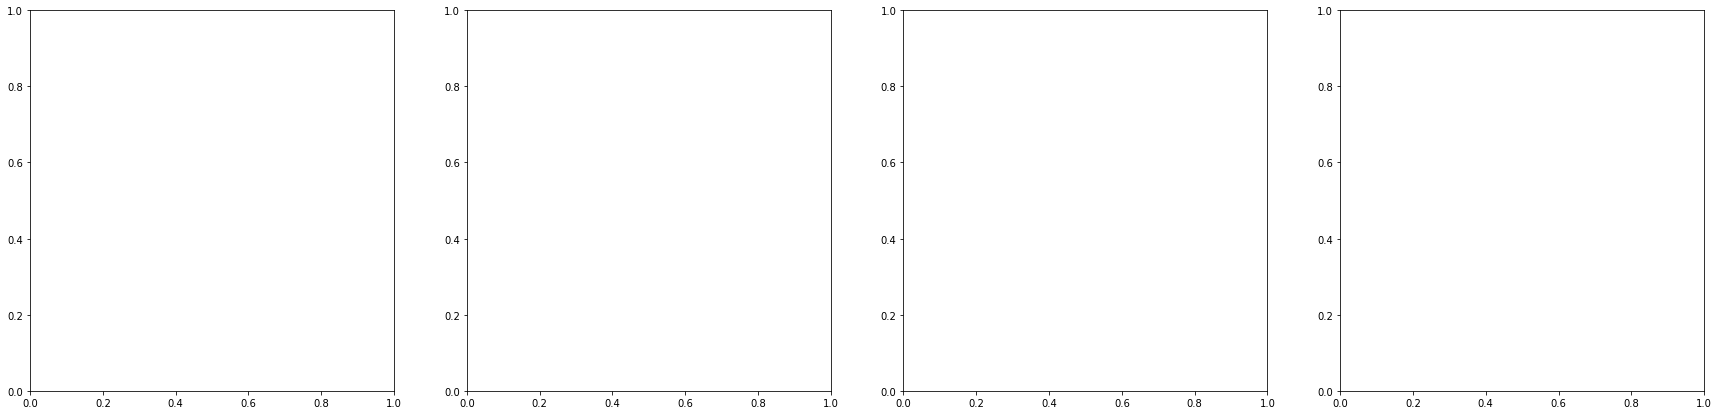

In [7]:
hots.plotlearning();

## Coding of the training set

In [ ]:
loader = get_loader(trainset)
num_sample_train = len(loader)
hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=True)

## Coding of the testing set

In [ ]:
loader = get_loader(testset)
num_sample_test = len(loader)
hots.coding(loader, testset.ordering, testset.classes, filtering_threshold, training=False)

## Classification with histogram (post-hoc)

In [ ]:
jitter = (None, None)

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

testset = HOTS_Dataset(test_path, trainset.sensor_size, transform=transform, dtype=trainset.dtype)
trainset = HOTS_Dataset(train_path, trainset.sensor_size, transform=transform, dtype=trainset.dtype)

In [ ]:
score = make_histogram_classification(trainset, testset, N_neuronz[-1])
print(f' Accuracy: {score*100}%')

## Online classification

In [ ]:
jitter = (None, None)
n_classes = len(testset.classes)

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

type_transform = tonic.transforms.NumpyAsType(int)

testset_output = HOTS_Dataset(test_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)

In [ ]:
trainloader = get_loader(trainset_output)
testloader = get_loader(testset_output)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
t_index = testset_output.ordering.index('t')
tau_cla = 2e4
jitter = (None,None)

if not os.path.exists('../Records/LR_results/'):
    os.mkdir('../Records/LR_results/')

model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
classif_layer, losses = fit_mlr(trainloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))
likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testloader,results_path,ts_size,testset_output.ordering)
meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes)
print(f'last accuracy: {lastac*100}%')